# Pokémon Sprite SVD Compression Notebook

This Jupyter Notebook demonstrates how Singular Value Decomposition (SVD) can be used to compress colour images, using 96×96 Pokémon sprites as the source dataset.

It will:
1. Automatically download a handful of sample sprites from the public PokeAPI sprite repository (front-facing non-shiny versions).
2. Display the original images.
3. Apply rank-k SVD approximations (k=5, 15, 30) separately to each RGB channel.
4. Plot side-by-side comparisons of original vs. reconstructed sprites, plus the Mean-Squared-Error (MSE) for each k.
5. Calculate the approximate compression ratio (ratio of stored SVD values vs. original pixel count) to illustrate space savings.




In [1]:
pip install numpy matplotlib pillow requests


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.8 MB 4.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/12.8 MB 4.6 MB/s eta 0:00:03
   --------- ------------------------------ 2.9/12.8 MB 4.7 MB/s eta 0:00:03
   ------------ --------------------------- 3.9/12.8 MB 4.7 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/12.8 MB 4.7 MB/s eta 0:00:02
   ------------------ --------------------- 5.8/12.8 MB 4.6 MB/s eta 0:00:02
   -------------------- ------------------- 6.6/12.8 MB 4.7 MB/s eta 0:00:02
   ----------------------- ---------------- 7.6/12.8 MB 4.7 MB/s eta 0:00:02
   --------------------------- ------------ 8.7/12.8 MB 4.7 MB/s eta 0:00:01
   ----------------------------- ---------- 9.4/12


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


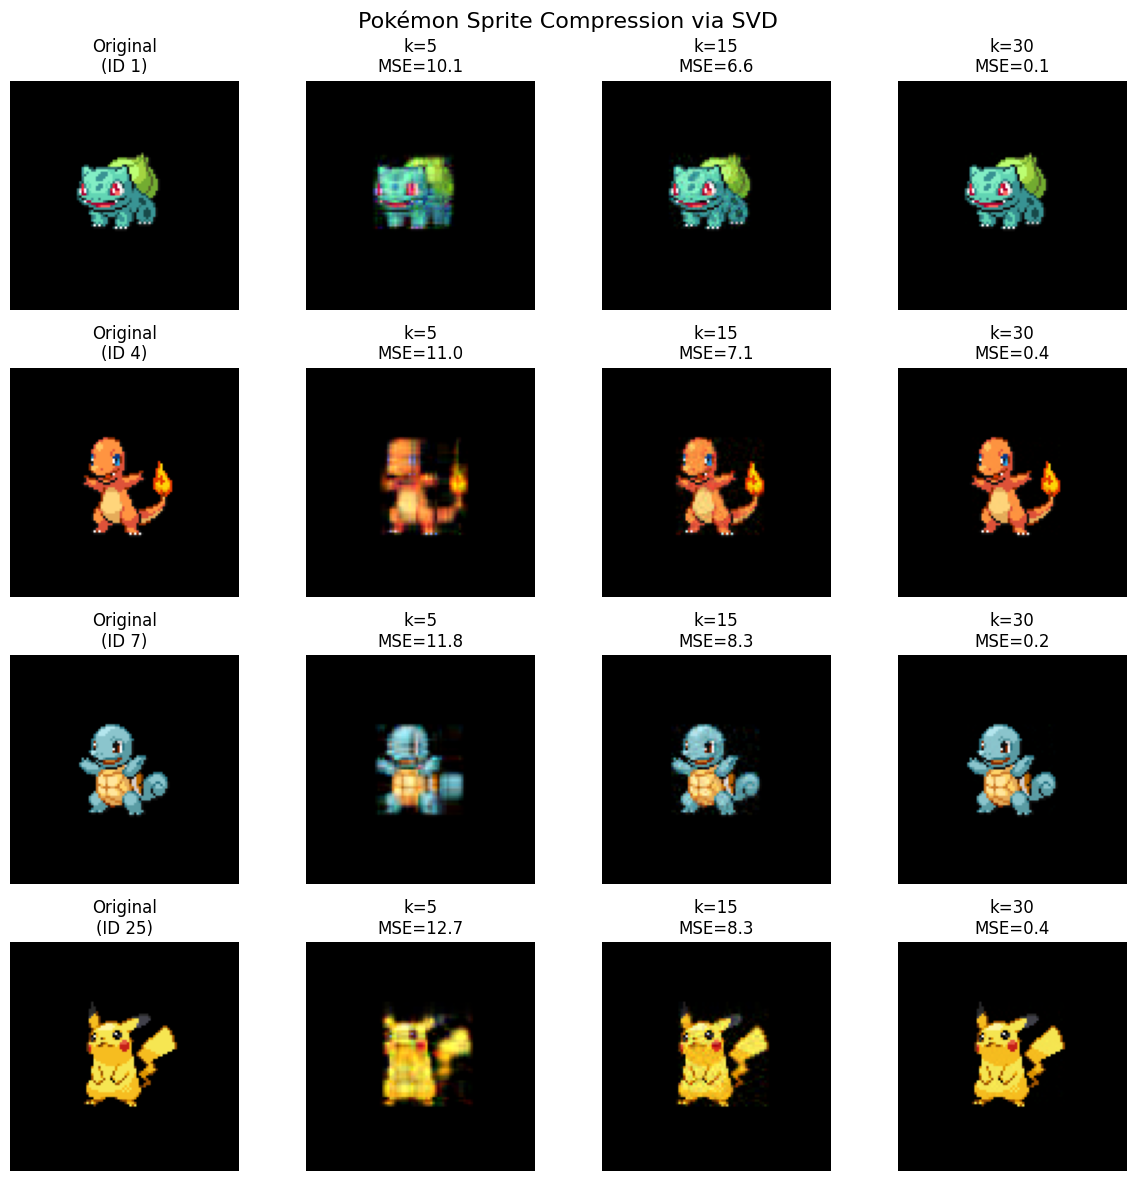

Original per-sprite size (RGB values): 27648
k=5: stored values = 965, compression ratio = 3.49%
k=15: stored values = 2895, compression ratio = 10.47%
k=30: stored values = 5790, compression ratio = 20.94%
Done! Now try experimenting with the Pokémon IDs list, k values, or pointing to a local sprite folder for more experiments.


In [5]:
## 1. Imports & Helper Functions
# Import required libraries and define the helper functions for downloading and compressing images.

# %%
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy.linalg import svd

# Set up the base URL for sprites and create a local output directory.
SPRITE_URL_TEMPLATE = "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{id}.png"
OUTPUT_DIR = "sprites"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define Pokémon IDs to download
POKEMON_IDS = [1, 4, 7, 25]  # Bulbasaur, Charmander, Squirtle, Pikachu

# Function to download a sprite image for a given Pokémon ID
def download_sprite(pokemon_id):
    """Download sprite and return as PIL.Image"""
    path = os.path.join(OUTPUT_DIR, f"{pokemon_id}.png")
    if not os.path.isfile(path):
        url = SPRITE_URL_TEMPLATE.format(id=pokemon_id)
        resp = requests.get(url)  # Fetch the sprite image from the internet
        resp.raise_for_status()
        with open(path, "wb") as f:
            f.write(resp.content)  # Save the image to disk
    return Image.open(path).convert("RGB")  # Open and convert to RGB format

# Function to apply SVD compression on a single image channel
def svd_compress_channel(channel_matrix, k):
    """Return the rank-k approximation of a 2D channel."""
    U, S, Vt = svd(channel_matrix, full_matrices=False)  # Perform full SVD
    Uk = U[:, :k]           # Take first k columns of U
    Sk = np.diag(S[:k])     # Take first k singular values and create a diagonal matrix
    Vk = Vt[:k, :]          # Take first k rows of V transpose
    return (Uk @ Sk @ Vk).clip(0, 255)  # Matrix multiplication and clip values to valid pixel range

## 2. Visualise and Compress
# For each Pokémon sprite, apply SVD compression at different ranks (k values) and display the results alongside the original.

ks = [5, 15, 30]  # Different levels of compression to test
fig, axs = plt.subplots(len(POKEMON_IDS), len(ks) + 1, figsize=(3 * (len(ks) + 1), 3 * len(POKEMON_IDS)))

for row, pid in enumerate(POKEMON_IDS):
    img = np.array(download_sprite(pid))  # Convert image to numpy array
    axs[row, 0].imshow(img)  # Show original image
    axs[row, 0].set_title(f"Original\n(ID {pid})")
    axs[row, 0].axis("off")

    for col, k in enumerate(ks, start=1):
        # Apply SVD compression to each color channel separately
        compressed_channels = [svd_compress_channel(img[:, :, c], k) for c in range(3)]
        # Stack the compressed channels back into a full image
        recon = np.stack(compressed_channels, axis=2).astype(np.uint8)

        mse = np.mean((img - recon) ** 2)  # Compute mean squared error
        axs[row, col].imshow(recon)  # Show reconstructed image
        axs[row, col].set_title(f"k={k}\nMSE={mse:.1f}")
        axs[row, col].axis("off")

plt.suptitle("Pokémon Sprite Compression via SVD", fontsize=16)
plt.tight_layout()
plt.show()

## 3. Compression Ratio Calculation
# Calculate the number of values needed to store each compressed version vs. the original size, and print the compression ratio.

# %%
height, width, channels = img.shape  # Get image dimensions
original_size = height * width * channels  # Total values in original RGB image
print(f"Original per-sprite size (RGB values): {original_size}")

for k in ks:
    # SVD stores U (h×k), S (k), and V (k×w) per channel
    svd_size = k * (height + width + 1)  # Values stored per channel (approx)
    ratio = svd_size / original_size     # Compression ratio
    print(f"k={k}: stored values = {svd_size}, compression ratio = {ratio:.2%}")

## 4. Wrap-up
# Print final message and suggestions for experimentation.

print("Done! Now try experimenting with the Pokémon IDs list, k values, or pointing to a local sprite folder for more experiments.")

